<a href="https://colab.research.google.com/github/Phuongbui2711/British-Airways-Virtual-Experience/blob/main/Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [90]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [ ]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [ ]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | BA standards continue to de...
1,Not Verified | Awful. Business class check in...
2,✅ Trip Verified | Not a reliable airline. You...
3,✅ Trip Verified | I take comfort in reading t...
4,✅ Trip Verified | The worst journey in my lif...


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#df.to_csv("data/BA_reviews.csv")
df.to_csv("/content/drive/MyDrive/Colab Notebooks/data/BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

## Data Cleaning

In [12]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/BA_reviews.csv")
df.head()

,Unnamed: 0,reviews
0,0,✅ Trip Verified | BA standards continue to de...
1,1,Not Verified | Awful. Business class check in...
2,2,✅ Trip Verified | Not a reliable airline. You...
3,3,✅ Trip Verified | I take comfort in reading t...
4,4,✅ Trip Verified | The worst journey in my lif...


In [14]:
# Classify verified vs not verified trip
df['verified'] = df['reviews'].str.contains("✅ Trip Verified") # must be "✅ Trip Verified" passed in the parameter, not "Trip Verified" only
df.head()

,Unnamed: 0,reviews,verified
0,0,✅ Trip Verified | BA standards continue to de...,True
1,1,Not Verified | Awful. Business class check in...,False
2,2,✅ Trip Verified | Not a reliable airline. You...,True
3,3,✅ Trip Verified | I take comfort in reading t...,True
4,4,✅ Trip Verified | The worst journey in my lif...,True


In [16]:
df['verified'].value_counts()

True     791
False    209
Name: verified, dtype: int64

In [15]:
# API pandas.Series.str.split to split text between "|" into two columns (expand=True), then keep the 2nd column
df['reviews'] = df['reviews'].str.split("|", expand=True)[1]
df.head()

,Unnamed: 0,reviews,verified
0,0,BA standards continue to decline every time ...,True
1,1,Awful. Business class check in queue just as...,False
2,2,Not a reliable airline. You cannot trust the...,True
3,3,I take comfort in reading the last ten or so...,True
4,4,The worst journey in my life. The connection...,True


In [ ]:
# Strip everything from the text and only keep the alphanumeric characters
import re
def clean_text(review):
  # By Python definition '\W == [^a-zA-Z0-9_], which excludes all numbers, letters and '_'
  review = re.sub(r'[^a-zA-Z0-9.]+', ' ', review)
  return review

df['reviews'] = df['reviews'].apply(clean_text)
df.head()

,Unnamed: 0,reviews
0,0,BA standards continue to decline every time I...
1,1,Awful. Business class check in queue just as ...
2,2,Not a reliable airline. You cannot trust the ...
3,3,I take comfort in reading the last ten or so ...
4,4,The worst journey in my life. The connection ...


Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
Words that have fewer than 3 characters are removed.
All stopwords are removed.
Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.
Words are stemmed — words are reduced to their root form.

In [114]:
import nltk, spacy, gensim
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from pprint import pprint
import matplotlib.pyplot as plt

In [83]:
def to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

words = list(to_words(df['reviews'].to_list()))

1000

In [84]:
# Load the spacy 'en_core_web_sm' model
spacy_model = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize(texts, postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = spacy_model(" ".join(sent))
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in postags]))
    return texts_out

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
lemmatized = lemmatize(words, postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

df.head()

,Unnamed: 0,reviews,verified,lemmatization
0,0,BA standards continue to decline every time ...,True,standard continue decline time fly time min la...
1,1,Awful. Business class check in queue just as...,False,awful business class check queue just as long ...
2,2,Not a reliable airline. You cannot trust the...,True,reliable airline trust timing at all flight bo...
3,3,I take comfort in reading the last ten or so...,True,take comfort read last so review see only trav...
4,4,The worst journey in my life. The connection...,True,bad journey life connection time only hour fli...


In [169]:
from pandas._libs.tslibs import vectorized
vectorizer = CountVectorizer(analyzer='word',
                             min_df=10,                        # minimum reqd occurences of a word
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

vectorized = vectorizer.fit_transform(lemmatized)
vectorized

<1000x845 sparse matrix of type '<class 'numpy.int64'>'
	with 36582 stored elements in Compressed Sparse Row format>

In [103]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=5,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',
                                      random_state=100,          # Random state
                                      batch_size=32,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(vectorized)

print(lda_model)

LatentDirichletAllocation(batch_size=32, learning_method='online',
                          n_components=5, n_jobs=-1, random_state=100)


In [106]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(vectorized)

# column names
topic_no = ["Topic " + str(i) for i in range(lda_model.n_components)]

# index names
rv_no = ["Review " + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_no, index=rv_no)

# Get dominant topic for each document
dominant_topic = np.argmax(df_topic.values, axis=1)
print()
df_topic['dominant_topic'] = dominant_topic

df_topic.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,dominant_topic
Review 0,0.30,0.00,0.69,0.00,0.00,2
Review 1,0.38,0.01,0.01,0.01,0.61,4
Review 2,0.00,0.00,0.92,0.00,0.07,2
Review 3,0.16,0.14,0.40,0.29,0.00,2
Review 4,0.00,0.00,0.20,0.63,0.16,3


In [165]:
df['topic'] = dominant_topic
df_0 = df.loc[df['topic'] == 0]
df_0.head()

,Unnamed: 0,reviews,verified,lemmatization,topic
5,5,"The airplanes and the lounges are worn out, o...",True,airplane lounge wear old broken heathrow multi...,0
23,23,"London Heathrow to Keflavik, Iceland in Busin...",True,keflavik iceland business class british provid...,0
24,24,Mumbai to London Heathrow in Business Class o...,True,mumbai heathrow business class ageing aircraft...,0
26,26,Flying A380 business class should be a pleas...,True,fly business class pleasure make disaster bad ...,0
32,32,"Filthy plane, cabin staff ok, appalling cust...",True,filthy plane cabin staff appalling customer se...,0


In [167]:
df_0['reviews'][5]

' The airplanes and the lounges are worn out, old and broken. From Dallas to Heathrow, multiple first class seating and electronics were non functional and poorly designed. The first class seating from Heathrow to Dubrovnik was nothing more than a tray blocking the middle seat of a standard coach ticket. Very disappointed.'

In [171]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,seat,class,business,food,good,economy,flight,cabin,service,crew,fly,meal,premium,club,offer
Topic 1,attendant,service,thank,ask,great,say,member,travel,tea,lady,absolutely,trip,amazing,request,staff
Topic 2,flight,airline,hour,service,seat,fly,staff,plane,people,time,bad,pay,customer,year,check
Topic 3,flight,cancel,day,book,tell,customer,hour,refund,bag,say,try,time,service,travel,make
Topic 4,flight,crew,time,check,good,food,staff,cabin,service,boarding,drink,hour,minute,delay,board


In [174]:
df_topic['dominant_topic'].value_counts()

0    308
4    268
3    263
2    141
1     20
Name: dominant_topic, dtype: int64

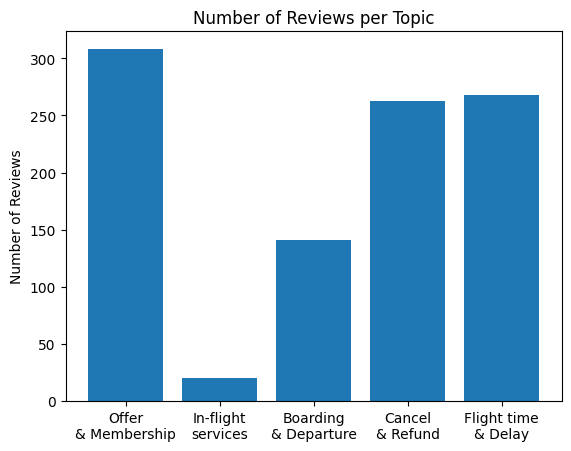

In [175]:
plt.bar(range(0, 5, 1), [308, 20, 141, 263, 268])
plt.ylabel("Number of Reviews")
plt.title("Number of Reviews per Topic")
x_labels = (["Offer\n& Membership", "In-flight\nservices",
            "Boarding\n& Departure","Cancel\n& Refund", "Flight time\n& Delay"])
plt.xticks(range(0, 5), x_labels)
# Show the graph
plt.show()

In [182]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


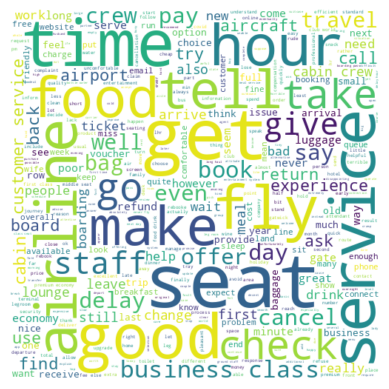

In [210]:
# starts with one review
plt.figure()

corpus = " ".join(df['lemmatization'])

stopwords = set(stopwords)

# create the word cloud  image
wordcloud=WordCloud(height = 500, width = 500, max_font_size=100, max_words=400 ,stopwords=stopwords, background_color ='white').generate(corpus)

plt.imshow(wordcloud , interpolation= 'bilinear', )
plt.axis("off")
plt.show()

In [190]:
import nltk.collocations as collocations
from nltk import FreqDist , bigrams

<Axes: >

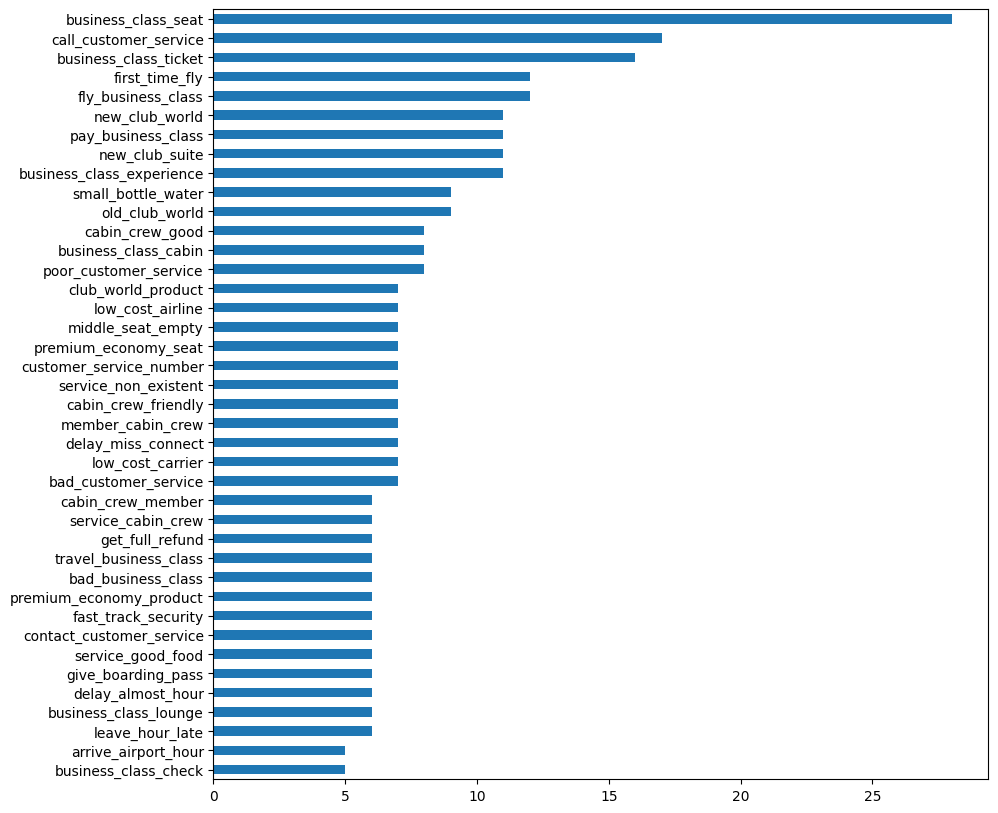

In [191]:
corpus = " ".join(df['lemmatization'])

# split the text of all reviews into list of words

words = corpus.split(" ")

new_words = [word for word in words if word not in stopwords]

def get_freq_dist(new_words , number_of_ngrams):
    from nltk import ngrams

    # Generat bigrams
    ngrams =ngrams(new_words , number_of_ngrams)

    # Creating FreqDist

    ngram_fd = FreqDist(ngrams).most_common(40)
    # Sort thr values by highest frequence
    ngrams_sorted = {k:v for k ,v  in sorted(ngram_fd , key= lambda item:item[1])}

    # Join bigram taken with '-' + maintain sorting
    ngram_joined = {'_'.join(k):v for k , v in sorted(ngram_fd , key= lambda item:item[1])}

    # Convert to pandas series for easy plotting
    ngram_freqdist = pd.Series(ngram_joined)
    plt.figure(figsize=(10,10))
    ax = ngram_freqdist.plot(kind="barh")

    return ax

get_freq_dist(new_words , 3)

In [192]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.7 MB/s eta 0:00:00


In [193]:
from transformers import pipeline

# Load pipeline to the classifier
classifier = pipeline("sentiment-analysis")

# Perform sentiment analysis on the first sample review
classifier(df['reviews'][0])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'NEGATIVE', 'score': 0.9997038245201111}]

In [194]:
# Apply pipeline on the whole dataset
def sentimentAnalysis(review):
  # Truncate the long review texts to max_length to fit the model
  cls = classifier(review, truncation=True, max_length=512)
  return(cls[0]['label'])

df['labels'] = df['reviews'].apply(sentimentAnalysis)
df.head()

,Unnamed: 0,reviews,verified,lemmatization,topic,labels
0,0,BA standards continue to decline every time ...,True,standard continue decline time fly time min la...,2,NEGATIVE
1,1,Awful. Business class check in queue just as...,False,awful business class check queue just as long ...,4,NEGATIVE
2,2,Not a reliable airline. You cannot trust the...,True,reliable airline trust timing at all flight bo...,2,NEGATIVE
3,3,I take comfort in reading the last ten or so...,True,take comfort read last so review see only trav...,2,NEGATIVE
4,4,The worst journey in my life. The connection...,True,bad journey life connection time only hour fli...,3,NEGATIVE


In [195]:
sentiment_count = df['labels'].value_counts()
sentiment_count

NEGATIVE    732
POSITIVE    268
Name: labels, dtype: int64

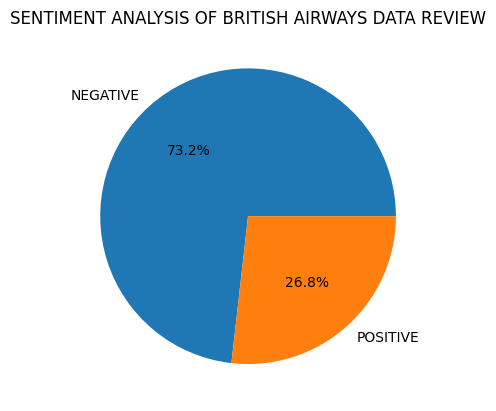

In [196]:
# Plot the analysis result as a pie chart
plt.pie(sentiment_count.values, labels=sentiment_count.index, autopct='%1.1f%%')
plt.title("SENTIMENT ANALYSIS OF BRITISH AIRWAYS DATA REVIEW")

# Export the plot
# plt.savefig('/data/BA_reviews_analysis.png')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/data/BA_reviews_analysis.png')

<Axes: xlabel='verified'>

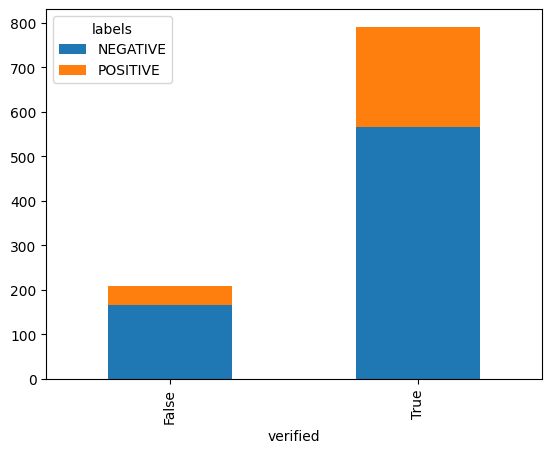

In [197]:
df.groupby('verified')['labels'].value_counts().unstack().plot.bar(stacked=True)

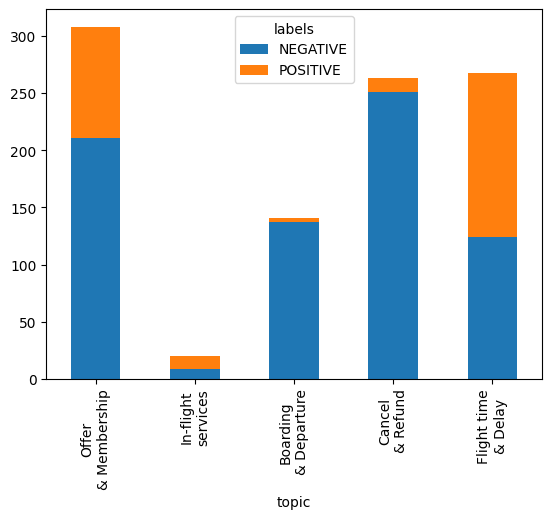

In [208]:
df.groupby(['topic'])['labels'].value_counts().unstack().plot.bar(stacked=True)
x_labels = (["Offer\n& Membership", "In-flight\nservices",
            "Boarding\n& Departure","Cancel\n& Refund", "Flight time\n& Delay"])
plt.xticks(range(0, 5), x_labels)
plt.show()

In [ ]:
# Save Sentiment Analysis dataframe to csv file
#df.to_csv("/data/BA_reviews_analysis.csv")
df.to_csv("/content/drive/MyDrive/Colab Notebooks/data/BA_reviews_analysis.csv")